# III. Агрегирование данных


Мы поговорим про **агрегирование данных**, которое помогает обощать информацию, получать сводную статистику и наглядно это визуализировать.

Один из наиболее распространенных случаев - группировка точек по полигонам. Этот метод применяется для изучения распределения объектов по территории, выявления закономерностей и наглядной визуализации пространственной информации.

Процесс включает в себя определение того, какие точки находятся внутри полигонов, а также расчет статистики по выбранным атрибутам этих точек для каждого полигона.

В этом разделе мы посмотрим, как можно агрегировать точечные данные по единицам административно-территориального деления (АТД) и по ячейкам регулярной сетки, которую научимся создавать самостоятельно и с помощью библиотеки [h3](https://uber.github.io/h3-py/intro.html) от Uber


**Импортируем библиотеки**


In [131]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## 3.1 Агрегирование по АТД


Давайте посчитаем количество театров в районах Санкт-Петербурга!

Для этого **прочитаем данные** с районами и театрами:


In [132]:
admin_district = gpd.read_file('data/spb_admin.gpkg', layer="district")
theaters = gpd.read_file('data/spb_theaters.geojson')

**Визуализируем** оба набора данных на карте


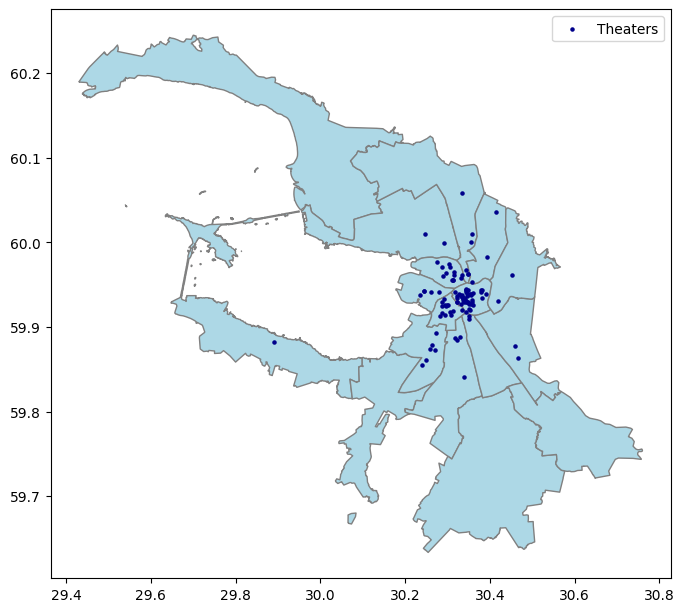

In [133]:
# создаем карту с районами города
ax = admin_district.plot(color='lightblue', edgecolor='gray', figsize=(8, 8))

# отображаем театры на этой же карте
theaters.plot(ax=ax, color='darkblue', markersize=5)

# добавляем легенду
plt.legend(['Theaters'])

# смотрим на результат
plt.show()

**Объединим данные** о театрах (theaters) с данными об административных районах (admin*district) с использованием пространственного предиката 'within' (внутри). *Для инструмента spatial join (sjoin) очень важно, чтобы объединяемые данные находились в одной системе координат\*


In [134]:
theaters_in_district = gpd.sjoin(theaters, admin_district, predicate='within')

**Группируем театры по районам** и посчитаем их количество в каждом


In [136]:
theaters_count = theaters_in_district.groupby('NAME').size().reset_index(name='theater_count')

**Объединяем количество театров по районам и набор данных с границами районов** и смотрим на результат!


In [138]:
admin_district_with_count = admin_district.merge(theaters_count, on='NAME', how='left')

admin_district_with_count.head()

NAME  Rayon_ID   Popul  \
0       Курортный район         1   79842   
1   Кронштадтский район         2   44290   
2      Приморский район         3  585554   
3  Петродворцовый район         4  142397   
4   Петроградский район         5  124132   

                                            geometry  theater_count  
0  MULTIPOLYGON (((29.42981 60.18954, 29.45195 60...            NaN  
1  MULTIPOLYGON (((29.63402 60.03155, 29.63406 60...            NaN  
2  MULTIPOLYGON (((29.95521 60.03745, 29.95523 60...            2.0  
3  MULTIPOLYGON (((29.64754 59.92986, 29.64951 59...            1.0  
4  MULTIPOLYGON (((30.21353 59.97239, 30.21368 59...           13.0

Мы получили количество театров в каждом районе Санкт-Петербурга!


Давайте **посчитаем количество театров на 10 тысяч человек** и отобразим это на карте


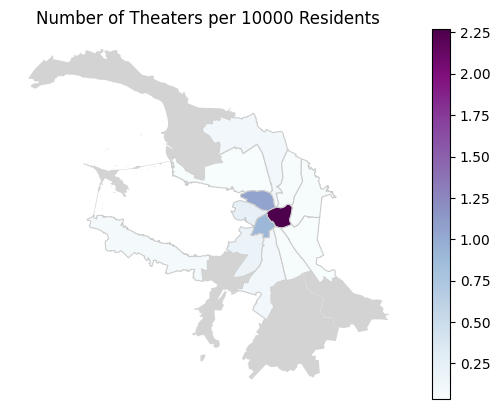

In [139]:
# считаем количество театров на 10000 человек
admin_district_with_count.eval('theaters_per_10000 = theater_count / (Popul/10000)', inplace=True)

# создаем карту с районами города, цвет которых зависит от рассчитанного показателя
ax = admin_district_with_count.plot(column='theaters_per_10000', cmap='BuPu', linewidth=0.8, edgecolor='0.8', legend=True)

# добавляем на карту районы, где нет театров
admin_district_with_count[admin_district_with_count['theaters_per_10000'].isna()].plot(color="lightgray", ax=ax)

# добавляем название
ax.set_title('Number of Theaters per 10000 Residents')

# скрываем координатные оси
ax.axis('off')

# смотрим на результат
plt.show()


Наверное, редко считают такую странную статистику по театрам в Петербурге. Но почему бы нет?!)


## 3.2 Агрегирование по ячейкам регулярной сетки


Регулярная сетка (grid / fishnet) помогает разбивать географическую область на равные ячейки. Этот метод обеспечивает структурированный и однородный способ дробления пространства, что позволяет равномерно агрегировать информацию без привязки к иным границам.


При создании ячеек регулярной сетки важно учитывать следующее:

1. **Размер ячеек:** Важно обеспечить достаточное разрешение для анализа данных, но при этом избегать излишнего дробления территории.

2. **Охват:** Убедитесь, что сетка покрывает всю интересующую вас область. Можно вычислить этот параметр на основе других наборов данных.

3. **Система координат:** При создании ячеек регулярной сетки важно учитывать используемую систему координат. Это поможет определить единицы измерения при расчете размера ячеек и избежать искажений формы.


### 3.2.1 Квадратные ячейки


Начнем с **определения системы координат** и **пространственного охвата**. И то, и другое будет основано на слое c районами Санкт-Петербурга, чтобы покрыть ячейками весь город


**Проверяем систему координат**


In [140]:
print(admin_district.crs.name)

WGS 84


Географическая система координат! Для удобства вычисления размера сетки и отсутствия искажений, нам нужно **перепроецировать данные в UTM**


In [141]:
#вычисляем нужную UTM зону
utm = admin_district.estimate_utm_crs()

#перепроецируем в нее данные
admin_district_utm = admin_district.to_crs(utm)


**Определяем экстент** (пространственный охват) нашего набора данных


In [142]:
#определяем границы
total_bounds = admin_district_utm.total_bounds

#записываем минимальные и максимальные значения для долготы и широты в отдельные переменные
minX, minY, maxX, maxY = total_bounds

**Выберем размер ячейки** (в метрах)


In [144]:
square_size = 1000

**Создадим регулярную сетку ячеек** в рамках заданного экстента


In [145]:
# создаем пустой список grid_cells для хранения ячеек сетки
grid_cells = []

# устанавливаем начальные значения переменных x и y равными минимальным значениям долготы и широты соответственно
x, y = (minX, minY)

# создаем пустой массив geom_array для хранения геометрий полигонов
geom_array = []

# внешний цикл, который продолжается до тех пор, пока значение y не достигнет или не превысит максимальное значение широты
while y <= maxY:
        # внутренний цикл, который продолжается до тех пор, пока значение x не достигнет или не превысит максимальное значение долготы
        while x <= maxX:
            # создаем полигон с координатами вершин, представляющими одну ячейку сетки, и добавляем его в массив geom_array
            geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            # увеличиваем значение x на размер стороны квадрата сетки для перехода к следующей ячейке по горизонтали
            x += square_size
        # сбрасываем значение x до минимального значения долготы для начала новой строки ячеек
        x = minX
        # увеличиваем значение y на размер стороны квадрата сетки для перехода к следующей строке ячеек
        y += square_size


# создаем GeoDataFrame fishnet из массива геометрий geom_array и назначаем ему столбец 'id' со значениями индексов
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32636')
fishnet['id'] = fishnet.index

**Посмотрим на результат**, познакомимся с библмотекой contextily для добавления базовых карт


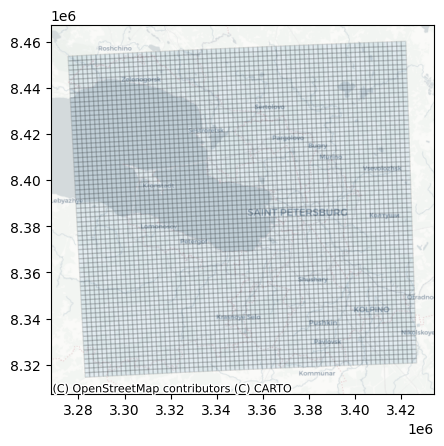

In [147]:
# импортируем библиотеку contextily
import contextily as ctx

# преобразуем координаты в EPSG:3857
fishnet_3857 = fishnet.to_crs('EPSG:3857')

# создаем карту
ax = fishnet_3857.plot(alpha=0.1, edgecolor='k')

# добавляем базовую карту CartoDB из библиотеки contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# посмотрим на карту
plt.show()



**Создадим функцию** для построения сетки регулярных ячеек на основе набора данных и размера


In [148]:
def create_regular_grid(gdf, square_size):

    #вычислеяем utm зоны для набора данных 
    utm_zone = gdf.estimate_utm_crs()
    #перепроецируем набор данных
    gdf = gdf.to_crs(utm_zone)
    minX, minY, maxX, maxY = gdf.total_bounds
    
    grid_cells = []
    x, y = minX, minY

    while y <= maxY:
        while x <= maxX:
            geom = Polygon([(x, y), (x, y + square_size), (x + square_size, y + square_size), (x + square_size, y), (x, y)])
            grid_cells.append(geom)
            x += square_size
        x = minX
        y += square_size

    fishnet = gpd.GeoDataFrame(geometry=grid_cells, crs=utm_zone)
    return fishnet

Проверим, как работает функция на примере набора данных theaters


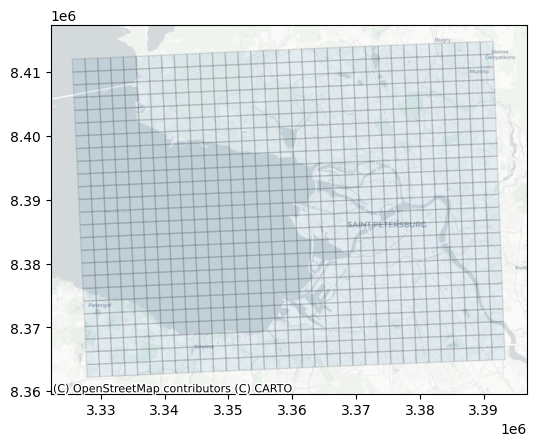

In [149]:
grid = create_regular_grid(theaters, 1000)

# преобразуем координаты в EPSG:3857
grid_3857 = grid.to_crs('EPSG:3857')

# создаем карту
ax = grid_3857.plot(alpha=0.1, edgecolor='k')

# добавляем базовую карту CartoDB из библиотеки contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# посмотрим на карту
plt.show()

Супер! Теперь путь к созданию регулярной сетки с квадратными ячейками стал на 15 строк короче


#### Сводная статистика на основе точек в полигонах - МКД


<p style="color:#00a6a6; font-style:italic"> 
Данные о многоквартирных домах (МКД) – один из прекрасных источников городских данных, из которого мы можем узнать не только различную информацию о состоянии жилого фонда, но и оценить численность населения в разных районах города
</p>

<p style="color:#00a6a6; font-style:italic"> 
В России есть <a href="https://аис.фрт.рф/opendata">Открытые данные Фонда развития территорий (реформа ЖКХ)</a>, где можно найти реестр всeх зарегистрированных многоквартирных домов (МКД) России. Для каждого МКД есть подробная информация, которая включает данные об адресе дома, жилой и нежилой площадях, этажности, годе постройки, наличии лифта и пр.
</p>

<p style="color:#00a6a6; font-style:italic"> 
Также данные можно искать на порталах открытых данных разных регионов. Так, для этого упражнения, мы взяли данные с платформы <a href='http://data.gov.spb.ru/opendata/'>Открытых данных Санкт‑Петербурга</a>
</p>


**Прочитаем данные из сsv**, создадим набор пространственных данных и посмотрим него


In [162]:
#Читаем csv
spb_mkd = pd.read_csv('data/spb_mkd.csv')

# Разделяем координаты в разные столбцы
spb_mkd[['latitude', 'longitude']] = spb_mkd['coordinates'].str.split(',', expand=True)
spb_mkd.drop(columns=["coordinates"], inplace = True)

# Создаем GeoDataFrame
spb_mkd_gdf = gpd.GeoDataFrame(spb_mkd, geometry=gpd.points_from_xy(spb_mkd['longitude'], spb_mkd['latitude']), crs=4326)

# Посмотрим на информацию об атрибутах 
#print(spb_mkd_gdf.info())

Очень много всего! Для разгадывания названий столбцов, нам бы пригодилась документация. Но сегодня нам понадобится только одно поле - data_residents с информацией о количестве проживающих в домах


**Посчитаем количество жителей в по ячейкам регулярной сетки** и таким образом увидим общие закономерности размещения населения в городе

**Объединим данные** МКД (theaters) с ячейками регулярной сетки (fishnet) с использованием пространственного предиката 'within' (внутри)


In [151]:
mkd_in_grid = gpd.sjoin(spb_mkd_gdf, fishnet, predicate='within')

/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_65948/4026174315.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32636

  mkd_in_grid = gpd.sjoin(spb_mkd_gdf, fishnet, predicate='within')


Ошибка! Данные должны быть в одной системе координат. Перепроецируем набор данных с МКД и попробуем снова


In [152]:
spb_mkd_gdf = spb_mkd_gdf.to_crs(spb_mkd_gdf.estimate_utm_crs())

mkd_in_grid = gpd.sjoin(spb_mkd_gdf, fishnet, predicate='within')

**Группируем МКД по ячейкам** и посчитаем сумму населения в каждой


In [154]:
population_count = mkd_in_grid.groupby('id')['data_residents'].sum().reset_index()

**Объединяем получившийся DataFrame со сводной статистикой и ячейки сетки** и смотрим на результат!


In [156]:
grid_with_population = fishnet.merge(population_count, on='id', how='left')

grid_with_population.explore(column="data_residents", tiles='cartodbpositron')

**Посчитаем плотность населения** (чел./кв.км) и отобразим на карте


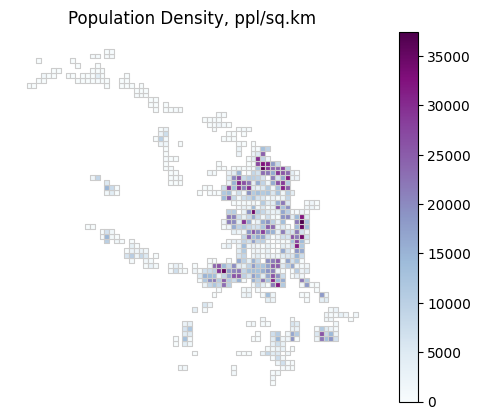

In [157]:
# вычисляем плотность населения: количество человек на 1 квадратный километр
grid_with_population.eval('pop_density = data_residents / (geometry.area / 10**6)', inplace=True)

ax = grid_with_population.plot(column='pop_density', cmap='BuPu', linewidth=0.8, edgecolor='0.8', legend=True)

# добавляем название
ax.set_title('Population Density, ppl/sq.km')

# скрываем координатные оси
ax.axis('off')

# смотрим на результат
plt.show()

### 3.2.2 Шестиугольные ячейки (H3 library)


Библиотека H3 для Python - инструмент для создания регулярных шестиугольных сеток. Она разработана компанией Uber. Разрешение ячеек определяет их размер и уровень детализации. Подробнее о размере ячеек на разных уровнях разрешения можно почитать [тут](https://h3geo.org/docs/core-library/restable/). У H3 также есть удобные методы встроенные методы для агрегирования и визуализации данных.


Для этой задачи мы с вами посмотрим на музеи еще одного прекрасного города - Вены

**Выгрузим данные о музеях** из OSM


In [160]:
import osmnx as ox

# выгрузим музеи Вены из ОСМ
museums_osm = ox.geometries.geometries_from_place("Vienna, Austria", tags={'tourism': 'museum'})

# оставим только точки
museums_osm = museums_osm.loc[museums_osm.geom_type.isin(['Point'])]

# посмотрим на них на карте
museums_osm.explore(tiles='cartodbpositron')


**Создадим шестиугольную сетку с помощью h3** и посчитаем количество музеев в ячейках


In [161]:
import h3

# устанавливаем разрешение H3 (8)
resolution = 8 

#преобразуем координаты музеев в шестиугольные ячейки H3 заданного разрешения
hexagons = [h3.geo_to_h3(lat, lon, resolution) for lat, lon in zip(museums_osm.geometry.x, museums_osm.geometry.y)]

# добавляем идентификаторы ячеек H3 к исходным данным о музеях
museums_osm['hex_id'] = hexagons

# подсчитываем количество музеев в каждой ячейке H3
museums_per_hex = museums_osm['hex_id'].value_counts().reset_index()
museums_per_hex.columns = ['hex_id', 'museums_count']

# получаем геометрию шестиугольных ячеек H3 на основе их идентификаторов
hexagon_geoms = [h3.h3_to_geo_boundary(hex_id) for hex_id in museums_per_hex['hex_id']]
hexagon_geoms = [Polygon(coords) for coords in hexagon_geoms]

# cоздаем GeoDataFrame с геометрией шестиугольных ячеек и данными о количестве музеев в каждой ячейке
hexagon_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(hexagon_geoms), data=museums_per_hex, crs="4326")

# смотрим, что получилось
hexagon_gdf.explore(column='museums_count', tiles='cartodbpositron')


## Итоги


Мы коротко посмотрели, **как агрегировать данные по единицам АТД и по ячейкам регулярной сетки**. Эта задача очень часто встречается в пространственной аналитике, так как помогает получить общую информацию о размещении объектов в пространстве.

Также познакомились с некоторыми новыми библиотеками: **contextily** для добавления картографических подложек на статичные карты и **h3** - для геоиндексации и агрегирования данных на шестиугольные ячейки регулярной сетки
